Import required libraries

In [6]:
import nltk
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



download necessary Natural language toolkit libriries for lemmen and tokenization

In [7]:
nltk.download(['punkt','punkt_tab','stopwords'], quiet=True)

True

separate data into train test sets

In [8]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Jana-Liebenberg/2401PTDS_Classification_Project/main/Data/processed/train.csv', sep=',', encoding='utf-8')
test_df = pd.read_csv('https://raw.githubusercontent.com/Jana-Liebenberg/2401PTDS_Classification_Project/main/Data/processed/test.csv', sep=',', encoding='utf-8')

View dimensions of graph

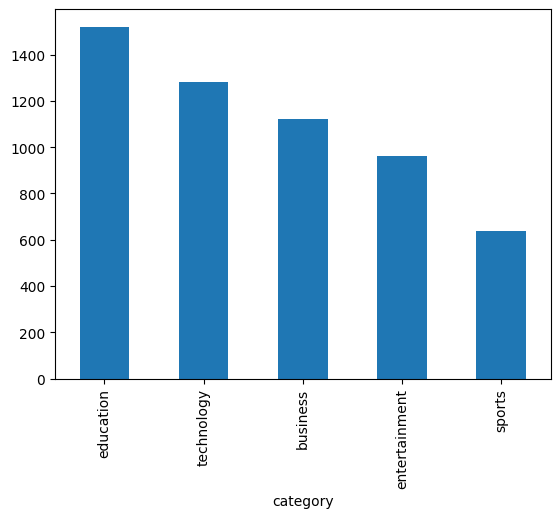

In [9]:
train_df['category'].value_counts().plot(kind='bar')
plt.show()

### 1) Format data
in the following order:
1) test on headline data given it is easier to split


In [10]:

def remove_punctuation_numbers_and_stopwords(text):
    text = text.lower()

    pun_nums = string.punctuation + "0123456789"
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(text)   #Tokenize text to find stopwords more easily 

    filterd_text = " ".join([w for w in word_tokens if w not in (stop_words and pun_nums)])

    second_check = re.sub(r'[^\w\s]','',filterd_text)

    return second_check

In [11]:
"""
Here we remove any punctuations and numbers that might have been in the data using the method declared
before for:
"""

#Headlines Data:
train_df['headlines'] = train_df['headlines'].apply(remove_punctuation_numbers_and_stopwords)
test_df['headlines'] = test_df['headlines'].apply(remove_punctuation_numbers_and_stopwords)

#Description Data:
train_df['description'] = train_df['description'].apply(remove_punctuation_numbers_and_stopwords)
test_df['description'] = test_df['description'].apply(remove_punctuation_numbers_and_stopwords)

#Content Data:
train_df['content'] = train_df['content'].apply(remove_punctuation_numbers_and_stopwords)
test_df['content'] = test_df['content'].apply(remove_punctuation_numbers_and_stopwords)

### 2) Feature Engeneering

In [12]:
""""
Here we format our target variables:

"""
y_train = train_df['category']
y_test = test_df['category']

y_train.shape

(5520,)

In [13]:
"""
Here we format our featurs:

Since CountVectorizer has a paramenter for stopwords, we dont need to implement a method
to identify them.

"""
def vectorize_data(column):
    vect = CountVectorizer(min_df=0.01)
    X_train = vect.fit_transform(train_df[column]).toarray()       #we use .toarray() to convert the matrix into a numpy array
    X_test = vect.transform(test_df[column]).toarray()

    return X_train, X_test

X_headlines_train, X_headlines_test = vectorize_data('headlines')
X_deascription_train, X_deascription_test = vectorize_data('description')
X_content_train, X_content_test = vectorize_data('content')


print('X_headlines-train:',X_headlines_train.shape)
print('X_headlines-test:',X_headlines_test.shape)

X_headlines-train: (5520, 151)
X_headlines-test: (2000, 151)


### 3) Model training  

Random Forest Accuracy: 0.6805

Classification Report:
                precision    recall  f1-score   support

     business       0.59      0.71      0.65       400
    education       0.78      0.82      0.80       400
entertainment       0.78      0.76      0.77       400
       sports       0.69      0.43      0.53       400
   technology       0.59      0.69      0.64       400

     accuracy                           0.68      2000
    macro avg       0.69      0.68      0.68      2000
 weighted avg       0.69      0.68      0.68      2000



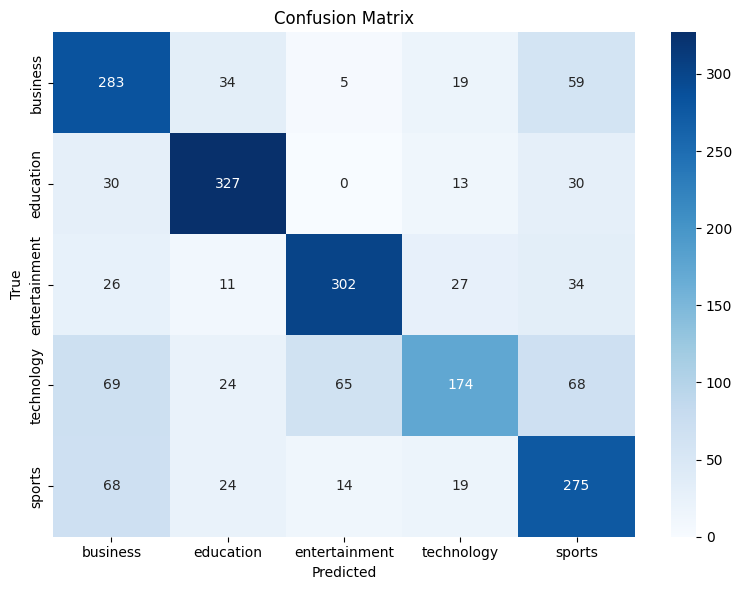

In [19]:

def fit_random_forest(X_train, y_train, X_test, y_test, class_names=None):
    """
    Trains a RandomForestClassifier, evaluates its performance, and generates a confusion matrix.

    Args:
        X_train: Training data features.
        y_train: Training data labels.
        X_test: Testing data features.
        y_test: Testing data labels.

    Returns:
        A tuple containing:
        - rf_model: The trained RandomForestClassifier model.
        - confusion_matrix_fig: A matplotlib figure of the confusion matrix.
        - accuracy: The accuracy of the model on the test set.
        - classification_report_str: A string representation of the classification report.
    """

    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Determine labels for the confusion matrix
    if class_names is None:
        labels = sorted(np.unique(np.concatenate((y_test, y_pred)))) #get all unique values
    else:
        labels = class_names

    # Create a figure for the confusion matrix
    confusion_matrix_fig = plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()

    #Generate classification report
    classification_report_str = classification_report(y_test, y_pred)

    return rf_model, confusion_matrix_fig, accuracy, classification_report_str


# Example Usage (assuming you have X_headlines_train, y_train, X_headlines_test, y_test defined)
# Create some dummy data for demonstration if you don't have it
class_names = y_test.unique()
clf_model, clf_graph, clf_accuracy, clf_report = fit_random_forest(X_headlines_train, y_train, X_headlines_test, y_test, class_names=class_names)

print('Random Forest Accuracy:', clf_accuracy)
print("\nClassification Report:\n", clf_report)
clf_graph.show() # Display the confusion matrix


Multinomial Naive Bayes Multi-Class Accuracy: 0.708

Classification Report:
                precision    recall  f1-score   support

     business       0.62      0.75      0.68       400
    education       0.79      0.80      0.80       400
entertainment       0.80      0.77      0.78       400
   technology       0.77      0.48      0.60       400
       sports       0.62      0.74      0.68       400

     accuracy                           0.71      2000
    macro avg       0.72      0.71      0.71      2000
 weighted avg       0.72      0.71      0.71      2000



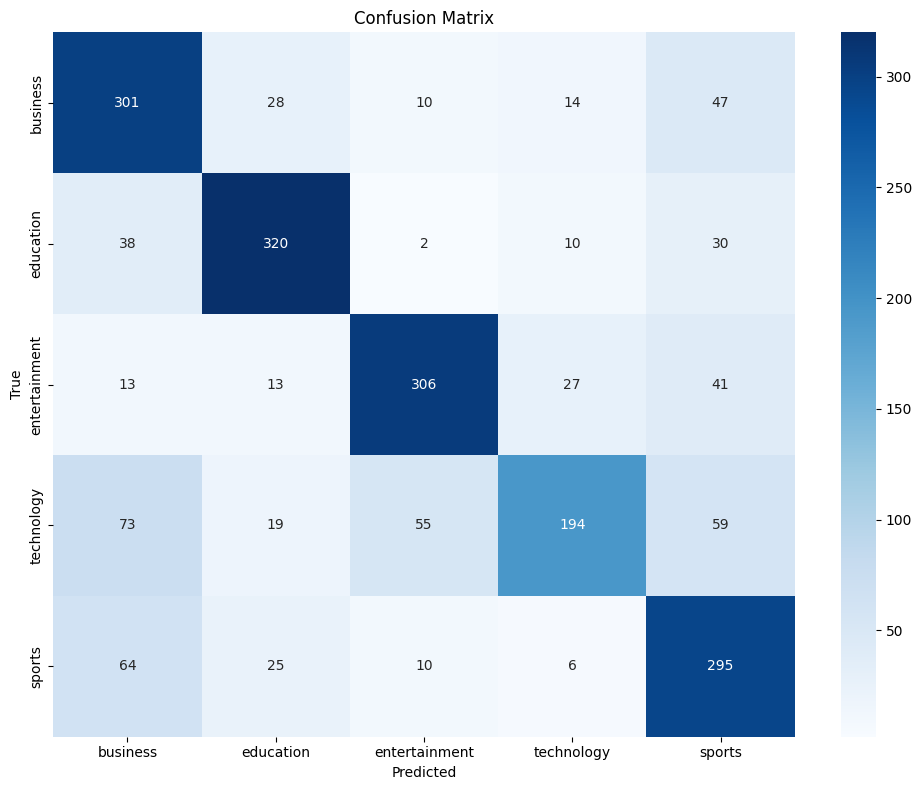

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def fit_multinomial_nb_multiclass(X_train, y_train, X_test, y_test, class_names=None):
    """
    Trains a Multinomial Naive Bayes classifier for multi-class classification,
    evaluates its performance, and generates a confusion matrix.

    Args:
        X_train: Training data features (should be non-negative counts).
        y_train: Training data labels.
        X_test: Testing data features (should be non-negative counts).
        y_test: Testing data labels.
        class_names: (Optional) A list of class names for better visualization
                     in the confusion matrix. If None, class labels will be used.

    Returns:
        A tuple containing:
        - nb_model: The trained MultinomialNB model.
        - confusion_matrix_fig: A matplotlib figure of the confusion matrix.
        - accuracy: The accuracy of the model on the test set.
        - classification_report_str: A string representation of the classification report.
    """

    nb_model = MultinomialNB()  # Initialize the Multinomial Naive Bayes model
    nb_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a figure for the confusion matrix
    confusion_matrix_fig = plt.figure(figsize=(10, 8))  # Increased size for potentially more classes

    # Determine labels for the confusion matrix
    if class_names is None:
        labels = sorted(np.unique(np.concatenate((y_test, y_pred)))) #get all unique values
    else:
        labels = class_names

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()

    # Generate classification report
    classification_report_str = classification_report(y_test, y_pred, target_names=class_names)

    return nb_model, confusion_matrix_fig, accuracy, classification_report_str


class_names = y_test.unique()
nb_model, nb_graph, nb_accuracy, nb_report = fit_multinomial_nb_multiclass(
    X_headlines_train, y_train, X_headlines_test, y_test, class_names=class_names
)

print('Multinomial Naive Bayes Multi-Class Accuracy:', nb_accuracy)
print("\nClassification Report:\n", nb_report)
nb_graph.show()  # Display the confusion matrix
